In [1]:
import gymnasium
import solar_plant_gym_env
import pandas as pd
env = gymnasium.make('solar_plant_gym_env/SolarPlant')


c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\envs\registration.py:525: UserWarning: WARN: Using the latest versioned environment `solar_plant_gym_env/SolarPlant-v0` instead of the unversioned environment `solar_plant_gym_env/SolarPlant`.
  logger.warn(


In [2]:
env.action_space

Discrete(3)

In [3]:
env.observation_space

Box(0.0, 1.0, (3,), float32)

In [4]:
import matplotlib.pyplot as plt

def plot_power_vs_time(df):
    """
    Plots the current power, battery charge, and total output power against the current time.
    
    Args:
        df: A pandas DataFrame containing columns: 'current_time', 'current_power', 'battery_charge', 'total_output_power'
    """
    # Ensure that the 'current_time' is in the correct format
    df['current_time'] = pd.to_datetime(df['current_time'], unit='s')

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot each of the columns
    plt.plot(df['current_time'], df['current_power'], label='Current Power', color='b', linestyle='-', marker='o')
    plt.plot(df['current_time'], df['battery_charge'], label='Battery Charge', color='g', linestyle='-', marker='x')
    plt.plot(df['current_time'], df['total_output_power'], label='Total Output Power', color='r', linestyle='-', marker='s')

    # Label the axes
    plt.xlabel('Current Time', fontsize=12)
    plt.ylabel('Power (W)', fontsize=12)

    # Add a title
    plt.title('Power and Battery Charge vs Time', fontsize=14)

    # Display the legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [5]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class SolarBatteryAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[float, float, float]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        obs = tuple(obs)
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[float, float, float],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[float, float, float],
    ):
        """Updates the Q-value of an action."""
        # Convert numpy arrays to tuples for dictionary keys
        obs = tuple(obs)
        next_obs = tuple(next_obs)
        # print (obs)
        # print (next_obs)
        
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [6]:
# arguments
time_step = 15
epi_days = 1
battry_cap =10000
battrry_charge_rate=40000
out_power_const =11000
data_file ='Plant_2_Generation_Data_cleaned.csv'

render_mode="human"

# # arguments
# time_step = 1
# epi_days = 1
# battry_cap =4000
# battrry_charge_rate=15000
# out_power_const =4500
# data_file ='Vydexa_lanka_data_cleaned.csv'

In [7]:
import gymnasium as gym
# import solar_plant_gym_env
# from solar_plant_gym_env.envs.solar_plant import SolarPlant

# hyperparameters
learning_rate = 0.001
n_episodes = 1000
start_epsilon = 2.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.01

# env = gym.make('solar_plant_gym_env/SolarPlant',render_mode="human")
env = gym.make('solar_plant_gym_env/SolarPlant',epi_days=epi_days,time_step=time_step, battry_cap = battry_cap,battrry_charge_rate = battrry_charge_rate,out_power_const =out_power_const,data_file=data_file)

env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = SolarBatteryAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\envs\registration.py:525: UserWarning: WARN: Using the latest versioned environment `solar_plant_gym_env/SolarPlant-v0` instead of the unversioned environment `solar_plant_gym_env/SolarPlant`.
  logger.warn(


In [8]:
from tqdm import tqdm

test_df= pd.DataFrame()

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    test_df = info['info_df']
    # plot_power_vs_time(info['info_df'])
    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        # rendered = env.render()
        # print(rendered)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
import matplotlib
matplotlib.use('TkAgg')  # Replace 'TkAgg' with 'Qt5Agg', 'MacOSX', etc., depending on your environment
import matplotlib.pyplot as plt

from tqdm import tqdm

n_epi_test = 10
test_env = gym.make('solar_plant_gym_env/SolarPlant',render_mode=render_mode,epi_days=epi_days, battry_cap = battry_cap,battrry_charge_rate = battrry_charge_rate,out_power_const =out_power_const,data_file=data_file)

for episode in tqdm(range(n_epi_test)):
    obs, info = test_env.reset()
    done = False

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = test_env.step(action)
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\envs\registration.py:525: UserWarning: WARN: Using the latest versioned environment `solar_plant_gym_env/SolarPlant-v0` instead of the unversioned environment `solar_plant_gym_env/SolarPlant`.
  logger.warn(
  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\utils\passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\utils\passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dt

In [ ]:
test_df

,current_time,current_power,battery_charge,total_output_power,action,reward
0,0.291667,82.746667,8248.686667,0.000000,0,-2221.000000
1,0.302083,318.206190,8328.238214,0.000000,0,-2221.000000
2,0.312500,593.287143,8476.560000,0.000000,0,-2221.000000
3,0.322917,1322.641429,8807.220357,0.000000,0,-2221.000000
4,0.333333,3743.650000,9743.132857,0.000000,0,-2221.000000
5,0.343750,7122.707143,10000.000000,6095.238571,0,-282.133693
6,0.354167,9356.278095,10000.000000,9356.278095,0,144.963566
7,0.364583,12306.028095,10000.000000,12306.028095,0,-1.130603
8,0.375000,13168.936667,10000.000000,13168.936667,2,-1.216894
9,0.385417,14446.750952,10000.000000,14446.750952,1,-1.344675


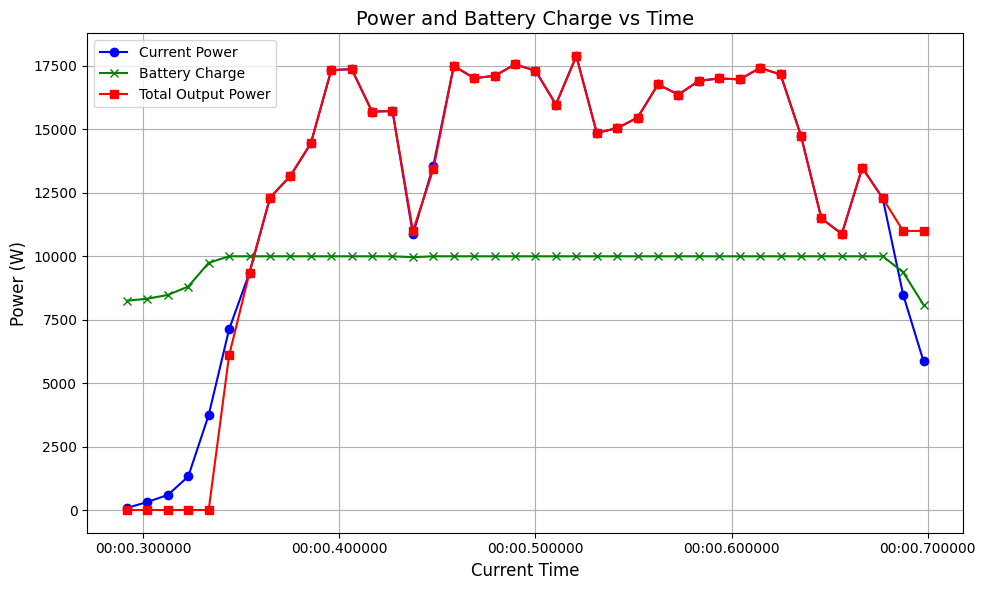

In [ ]:
plot_power_vs_time(test_df)

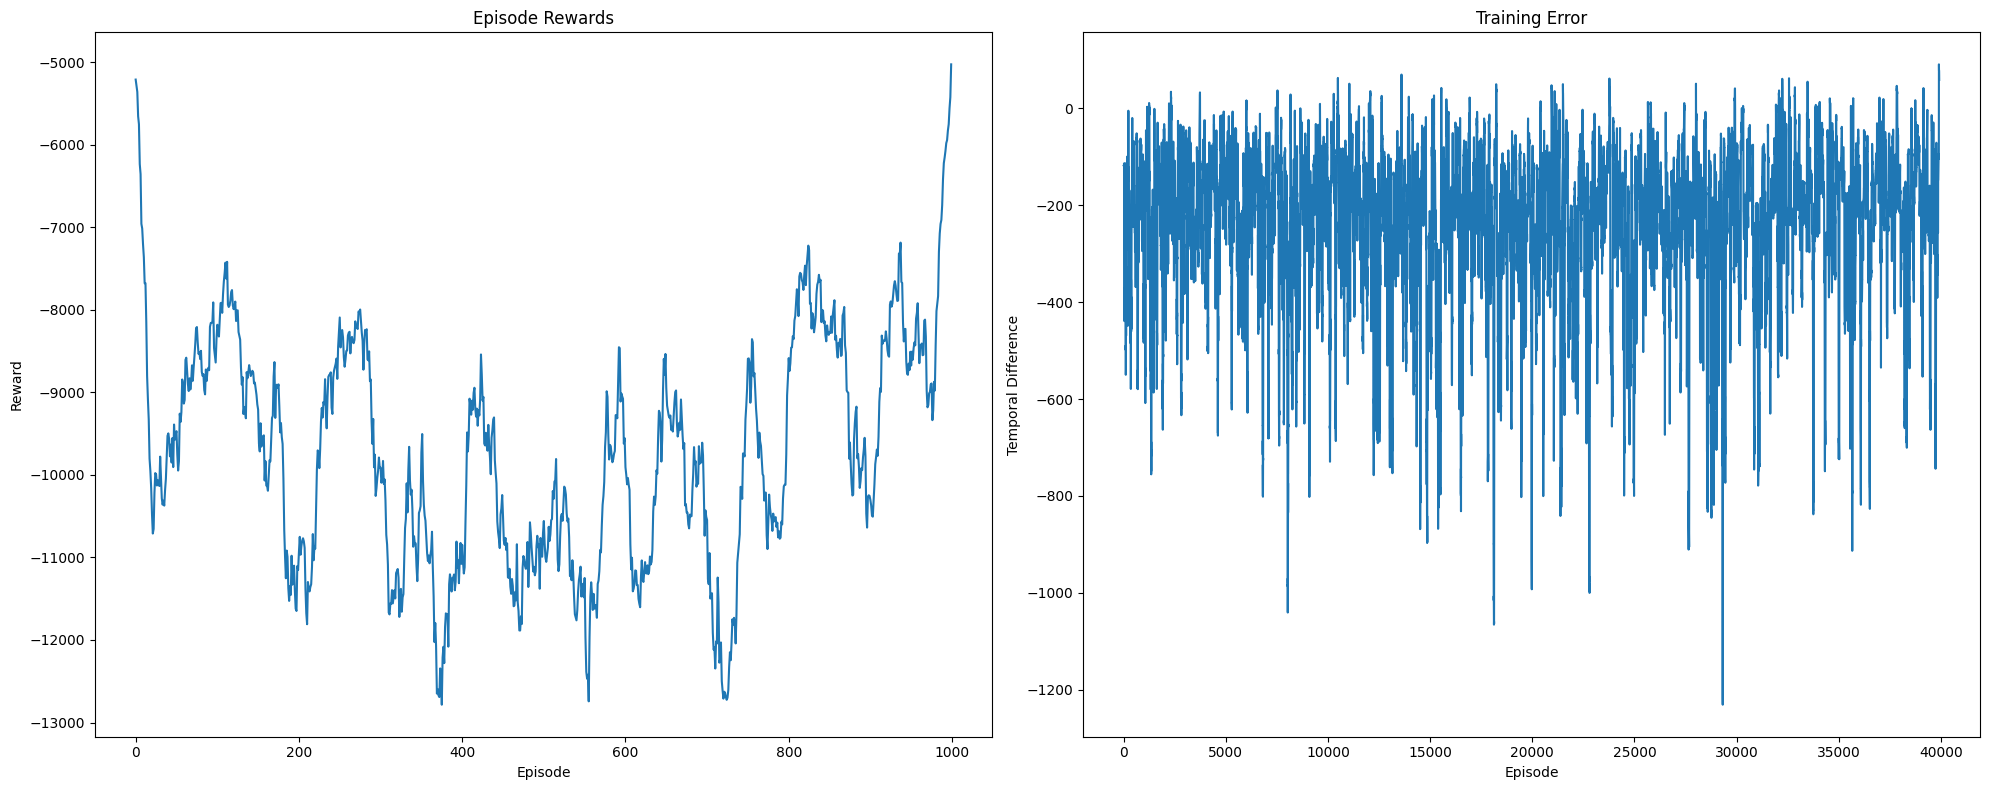

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes
kernel = np.ones(40) / 40  # Normalized kernel for moving average

# Plot Episode Rewards
axs[0].plot(np.convolve(env.return_queue, kernel, mode='same'))  # Use 'same' for matching output size
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

# Plot Training Error
axs[1].plot(np.convolve(agent.training_error, kernel, mode='same'))  # Normalized moving average
axs[1].set_title("Training Error")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()


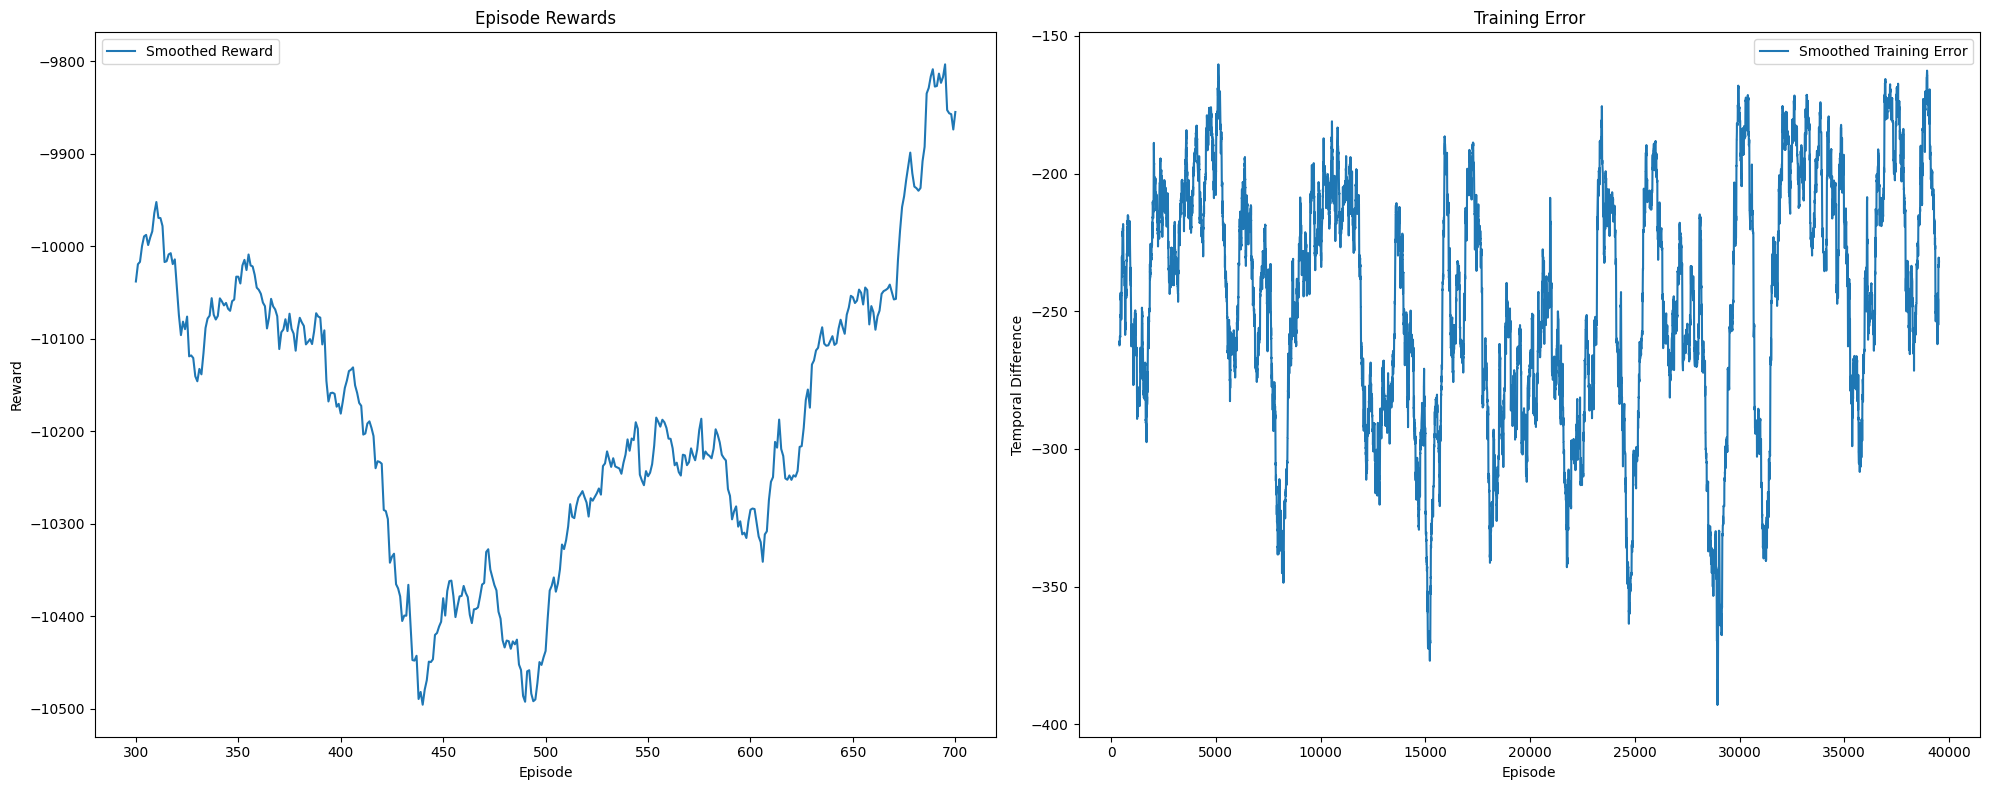

In [ ]:
import pandas as pd

# Convert the reward queue and training error to Pandas Series
reward_series = pd.Series(env.return_queue)
error_series = pd.Series(agent.training_error)

# Compute the rolling mean with a window of 100
reward_smooth = reward_series.rolling(window=600, center=True).mean()
error_smooth = error_series.rolling(window=800, center=True).mean()

# Visualize the smoothed data
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Episode Rewards
axs[0].plot(reward_smooth, label="Smoothed Reward")
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")
axs[0].legend()

# Training Error
axs[1].plot(error_smooth, label="Smoothed Training Error")
axs[1].set_title("Training Error")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Temporal Difference")
axs[1].legend()

plt.tight_layout()
plt.show()
